# Lidar Data

## Introduction 

LiDAR (Light Detection and Ranging) sensors are critical for autonomous vehicles to perceive their 3D surroundings. They emit laser pulses and measure the reflected light to create detailed point cloud data representing object surfaces in three dimensions.

These point clouds form the foundation for various functionalities in autonomous vehicles, including:

* **3D Object Detection:** Identifying and classifying objects like pedestrians, vehicles, and traffic signs.

* **Object Tracking:** Monitoring the movement and behavior of objects in the environment.

* **Localization and Mapping:** Determining the vehicle's position within the environment and building a real-time map of the surroundings.

## Point Cloud Data

Point clouds are collections of 3D data points representing object surfaces or environments. Each point has coordinates (x, y, z) in a common reference system and may include additional information like:

* **Color (RGB values):** Visual representation of the surface.

* **Intensity:** Strength of the reflected laser pulse.

* **Additional data fields (optional):** Can include reflectivity, distance from the reference to the point (range) or time of point acquisition properties depending on the LIDAR in use.


### PCD file format

The PCD (Point Cloud Data) format is a widely used method for storing and manipulating point cloud data. It's specifically designed to represent the points with all the fields, in a simple way.

A PCD file consists of two main parts:

1. **Header:** Contains metadata about the point cloud, including:
    * PCD format version
    * Point data fields present (e.g., x, y, z, RGB)
    * Size and data type (e.g., float, int) of each field
    * Total number of points in the cloud

2. **Data Section:** Stores the actual point cloud data. Points can be saved in either:

    * ASCII format: Human-readable text format, larger file size.
    *   Binary format: Compact and faster to process programmatically, not human-readable.

### Reading PCD in Python

Considering point clouds are fundamentally arrays of points, Python's NumPy library is an excellent tool for processing these points. However, before we can leverage NumPy, we must first utilize a method to parse the point data from a file into the program. To achieve this, several libraries facilitate reading different 3D modeling file formats.

Specifically, for handling **".pcd"** files, we utilize the <code>pypcd</code> library. This library is adept at serializing point data from files and, using this data, generates NumPy arrays of points. 

It is important to emphasize the versatility of the "pcd" format; it supports various fields for each point, allowing them to be independently encoded with different data types, including integers and floating-point numbers of different sizes.

In [1]:
# General imports

from PIL import Image
from typing import Tuple
from easydict import EasyDict as edict

import numpy as np
from numpy.lib.function_base import percentile
import numpy.lib.recfunctions as rf

from pypcd import pypcd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tools import plot_tools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def numpy_from_pcd(path):
    """Loads pointclouds from pcd files

    Parameters
    ----------
        file (str): .pcd file
    Returns:
        pcl (np.ndarray): pointcloud as a numpy array of shape [n_points, m_channles]
                          n_points is calculated by lidar VFOV*HFOV
    """
    assert path[-3:] == 'pcd', 'Only "pcd" format is accepted.'
    pcd = pypcd.PointCloud.from_path(path)
    pcd = np.asarray(pcd.pc_data)
    return rf.structured_to_unstructured(pcd)

# Parse points from pcd file
pcl_1 = numpy_from_pcd("example_data/frame_32.pcd")
pcl_2 = numpy_from_pcd("example_data/frame_36.pcd")
plot_tools.show_pcl(pcl_2)


## Range Images

Encoding data as raw pointclouds is often inefficient in terms of memory use and processing power. Alternatively, using range images to encode pointclouds from datasets is a more efficient and compact method, particularly for interpreting Lidar data.

A range image is obtained by converting a pointcloud into a two-dimensional array where each pixel represents a point in the pointcloud, with the pixel's value indicating the distance from the sensor to that point. This format efficiently organizes the data in a way that reflects the sensor's perspective in a structured, grid-like fashion.

* **Efficiency:** Storing pointcloud data as range images significantly reduces the computational load. Algorithms can process data in a 2D array format, exploiting the inherent efficiency of image processing techniques.
    
* **Compactness:** Range images represent a dense format, minimizing the storage space required for Lidar data. This is especially beneficial for systems with limited storage capacity.

* **Integration with Vision Systems:** Autonomous vehicles often rely on multiple sensing modalities. Encoding Lidar data as range images facilitates the integration with camera-based vision systems, enabling more robust perception algorithms that leverage both LiDAR and visual cues.
    
* **Simplicity in Data Handling:** Working with range images simplifies the handling of pointcloud data. Techniques such as convolutional neural networks (CNNs) can be directly applied for tasks like object detection, segmentation, and classification, benifiting of the depth information that the image encodes.

### From Pointcloud to Range Image

Let's calculate the range image from the pointcloud data. Pointclouds represent objects in 3D space through coordinates ($x$, $y$, $z$) relative to the sensor's position. Given our focus on mechanical scanning LIDARs, these devices employ mechanical means to sweep the environment, measuring the distances to surfaces in a 360-degree view. In specific 3D Mechanicals LIDARs stack multiple lasers, each at a fixed elevation, allowing for the capture of points in spherical coordinates ($r$, $\theta$, $\phi$), where:

* $r$ is the range, or the distance from the sensor to the point.
* $\theta$ is the azimuth angle, the angle between the x-axis and the projection of the point in the $xy$-plane.
* $\phi$ is the elevation angle, the angle between the point and the $xy$-plane.

The resulting range image is derived by mapping these coordinates onto an image, where the $x,y$ positions of each pixel correspond to the $\theta$, $\phi$ components respectively, and the pixel's value is determined by the range $r$.

To calculate the range image from the pointcloud, we follow three main steps:

1. **Coordinate Transformation:** Transform the Cartesian coordinates $(x,y,z)$ into spherical coordinates $(r,\theta,\phi)$, where:
$$
r=\sqrt{x^2+y^2+z^2}
$$​
$$
\theta=\arctan{\left(\frac{y}{x}\right)}
$$
$$
\phi=\arcsin⁡{\left(\frac{z}{r}\right)}
$$

2. **Filtering and Normalization:** Before mapping the points to a 2D grid, it's often necessary to filter the data to remove outliers and to normalize the azimuth and elevation angles. This step ensures that the angles fit within the expected range of values that correspond to the sensor's field of view. In our case, we will get rid of <code>NaN</code> values from $\phi$ as there are usually null ranges on the pointclouds.

3. **Mapping to 2D Grid:** Spherical coordinates are then mapped onto a 2D grid, representing the range image. The grid's dimensions align with the LIDAR sensor's resolution and field of view. Each grid pixel coordinate $(u,v)$ corresponds to an azimuth-elevation angle pair $(\theta, \phi)$, with its value reflecting the range to the nearest obstacle. To achieve this mapping: 

    1. Determine the range image's dimensions. These are defined by the LIDAR's number of layers (height of the range image) and the points per layer (width of the range image).
    2. For each point calculate the $(u,v)$ coordinates on the range image based on their $\theta$ and $\phi$ values. For this we can use a linear interpolation.
        * $u_i$: Map the $i^{th}$-point azimuth angle $\theta_i$ from the range $[-\pi, \pi]$ to the range $[0, w]$, where $w$ is the points per layer.

        $$
        u_i = \frac{\theta_i + \pi}{ 2\pi } *(w-1)
        $$
        * $v_i$: Map the $i^{th}$-point elevation angle $\phi_i$ from the range $[\phi_{min}, \phi_{max}]$ to the range $[h, 0]$, where $\phi_{min}$ and $\phi_{max}$ is the LiDAR maximun a minimun elevation angle respectively and $h$ the number of layers.
        $$
        v_i = \frac{\phi_{max} - \phi_i}{\phi_{max} - \phi_{min}} *(h-1)
        $$
        
    3. Create an array of shape $(h,w)$ to store the range image. Assing the range value of the $i^{th}$-point to the correspoinding pixel at coordinate $(u_i, v_i)$ of the range image.

#### Python Implementation

/tmp/ipykernel_1909/1042148623.py:16: RuntimeWarning: invalid value encountered in divide
  elevations = np.arcsin(z / ranges)


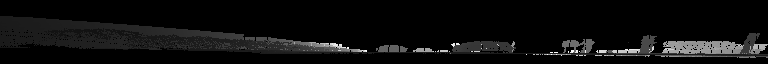

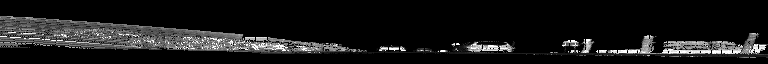

In [3]:

def pointcloud_to_range_image(pcl:np.ndarray, lidar_config: edict) -> np.ndarray:
    width = lidar_config.points_per_layer
    height = lidar_config.n_layers
    fov_up = lidar_config.fov_up * np.pi /180
    fov_down = lidar_config.fov_down * np.pi / 180.0
    
    # Step 1:
    # Calculate range and angles for each point
    x = pcl[:, 0]
    y = pcl[:, 1]
    z = pcl[:, 2]
    channels_info = pcl[:, 3:]

    ranges = np.sqrt(x*x+y*y+z*z)
    azimuths = np.arctan2(y, x)
    elevations = np.arcsin(z / ranges)

    # Step 2:
    elevations[np.isnan(elevations)] = 0
    
    # Step 3:
    # 3.2: Convert range and angles to pixel coordinates
    #Rows of the image 
    vs = np.round(((fov_up - elevations) / (fov_up - fov_down)) * (height-1)).astype(np.int32) 
    #Columns index of the image
    us = np.round(((azimuths + np.pi) / (2*np.pi)) * (width - 1)).astype(np.int32)
    
    # 3.3: 
    # Create image placeholders filled with 0.
    range_image = np.zeros((height, width), dtype=np.float32)
    intensity_image = np.zeros((height, width, pcl.shape[1]-3), dtype=np.float32)
    # Populate image
    range_image[vs, us] = ranges
    intensity_image[vs, us] = channels_info
    
    #  Stack channels as we also want to add the intensity to our image
    range_channels_image = np.dstack((range_image, intensity_image))
    
    return range_channels_image

def show_range_image(range_image):
    ri = range_image.copy()
    deg45 = int(ri.shape[1]/8)
    ri_center = int(ri.shape[1]/2)
    ri = ri[:,ri_center-deg45:ri_center+deg45,:]
    #  map the range channel onto an 8-bit scale and make sure that the full range of values is appropriately considered
    ri_range = ri[:,:,0]
    ri_range = (ri_range-np.amin(ri_range)) * 255 / (np.amax(ri_range) - np.amin(ri_range))
    # map the intensity channel onto an 8-bit scale and normalize with the difference between the 1- and 99-percentile to mitigate the influence of outliers
    ri_intensity = ri[:,:,1]
    p99 = percentile(ri_intensity,99)
    p1  = percentile(ri_intensity,1), 
    ri_intensity = np.clip(ri_intensity, p1, p99)
    ri_intensity = 255*(ri_intensity-p1)/(p99-p1)
    # stack the range and intensity image vertically using np.vstack and convert the result to an unsigned 8-bit integer   
    img_range_intensity = np.vstack((ri_range, ri_intensity)).astype(np.uint8)
    Image.fromarray(ri_range.astype(np.uint8)).show()
    Image.fromarray(ri_intensity.astype(np.uint8)).show()
    return img_range_intensity


lidar_config = edict()
lidar_config.points_per_layer = 3072
lidar_config.n_layers = 64
lidar_config.fov_up = 25
lidar_config.fov_down = -5

ri = pointcloud_to_range_image(pcl_2, lidar_config)
_ = show_range_image(ri)


### Pointcloud from Range image

Range images are useful because they provide an image of the environment without losing any of the information about its depth. This enables the application of 2D object detection methods to identify objects within the 2D plane and subsequently project their coordinates into three-dimensional (3D) space.

However, a 3D representation derived from LIDAR data is essential for certain processes such as localisation, mapping and navigation. For this reason, it is important to understand the methods used to convert range images to point clouds, or in other words, the transformation of a point from spherical coordinates to Cartesian coordinates.

Converting range images to point clouds requires mapping each pixel within the range image to a corresponding point in 3D space. This mapping process relies on a thorough understanding of the sensor's intrinsic parameters, including its field of view (FoV) and range image resolution. 

To calculate the pointcloud from the range image, we follow these main steps:

1. **Identify LiDAR Operation Range:** Determine the operational range of the LiDAR sensor that produced the range image. Specifically, obtain the maximum and minimum elevation angles, $\phi_{max}$ and $\phi_{min}$ respectively, from the sensor's datasheet. Although the number of layers and points per layer directly correspond to the range image's height and width, understanding the operational range is neccesary for interpreting the data. The goal is to construct an array of points $P$ with the shape $(h\times w, \text{num of channels})$, where $h$ and $w$ represent the height (number of layers) and width (points per layer) of the range image, respectively.

2. **Calculate Azimuth and Elevation Angles:** In the range image, each pixel (or cell) at coordinates $(i,j)$ is defined by its range $r_{ij}$, azimuth angle $\theta_i$, and elevation angle $\phi_j$. It's crucial to understand that $\theta_i$ represents the azimuth angle shared by all pixels in column $i$, and $\phi_j$ represents the elevation angle common to all pixels in row $j$. These angles are uniformly distributed across the LIDAR's operational range. The formulas to calculate these angles are as follows::

    $$\theta_i = -\pi + i*\Delta \theta$$
    $$\phi_j = \phi_{min} + j * \Delta \phi$$

   Use <code>numpy.linspace</code> to create arrays of linearly spaced values within the FOV limits, specifically between $[\phi_{min}, \phi_{max}]$ for elevation angles and $[-\pi, \pi]$ for azimuth angles. These arrays correspond to the elevation and azimuth angles for each row and column of the range image, respectively.

3. Convert the Spherical coordinates (range and angles) to Cartesian coordinates. Instead of iterating over each point with nested loops, which is computationally expensive, use <code>numpy.meshgrid</code>. A meshgrid takes two 1D arrays and produces two 2D grids. One grid corresponds to the X-coordinates and the other to the Y-coordinates of points in a meshgrid formed by pairing each element of the first input array with each element of the second input array. This operation essentially prepares the azimuth (X-coordinates) and elevation (Y-coordinates) angles for each pixel in the range image in a matrix format. 

    The conversion from Spherical coordinates to Cartesian coordinates can be done using the following formulas:

    $$
    x = r \cos{\phi} \cos{\theta}
    $$​
    $$
    y = r \cos{\phi} \sin{\theta}
    $$
    $$
    z = r\sin{\theta}
    $$



4. Create an empty array $P$ of shape $(h\times w, \text{num of channels})$ and assign.

$$
P[:,0] \rightarrow x
$$
$$
P[:,1] \rightarrow y
$$
$$
P[:,2] \rightarrow z
$$

5. Finally, filter out any points with non-finite values $(\text{NaN}, \infty)$ to ensure that the point cloud only contains valid points.

In [4]:

def pointcloud_from_range_image(ri, lidar_config):
    # Step 1: 
    # Convert FOV values from degrees to radians
    fov_up = lidar_config.fov_up * np.pi / 180.0
    fov_down = lidar_config.fov_down * np.pi / 180.0
    
    # Calculate vertical and horizontal FOV angles
    height, width, channels = ri.shape
    
    # Step 2: 
    # Calculate range and angles for each pixel
    elevations = np.linspace(fov_up, fov_down, height)
    azimuths = np.linspace(-np.pi, np.pi, width)
    azimuths, elevations = np.meshgrid(azimuths, elevations)
    ranges = ri[:,:,0]
    
    # Step 3: 
    # Convert range and angles to Cartesian coordinates
    x = ranges * np.cos(elevations) * np.cos(azimuths)
    y = ranges * np.cos(elevations) * np.sin(azimuths)
    z = ranges * np.sin(elevations)
    
    # Step 4:
    # Create empty point cloud array
    pcl = np.zeros((height * width, 3+(channels-1)), dtype=np.float32)
    # Fill in point cloud array
    pcl[:, 0] = x.flatten()
    pcl[:, 1] = y.flatten()
    pcl[:, 2] = z.flatten()

    pcl[:,3:] = np.reshape(ri[:,:,1:], (height*width,-1))
    
    # Step 5:
    # Filter out invalid points
    valid_indices = np.where(np.isfinite(pcl).all(axis=1))[0]
    pcl = pcl[valid_indices]
    
    return pcl

lidar_config = edict()
lidar_config.points_per_layer = 3072
lidar_config.n_layers = 64
lidar_config.fov_up = 25
lidar_config.fov_down = -5

pcl_reconstructed = pointcloud_from_range_image(ri,lidar_config)
plot_tools.show_pcl(pcl_reconstructed)

## BEV from PCL

For many applications, including navigation and obstacle avoidance, it is beneficial to process this data into a Bird's Eye View (BEV) representation. A Bird Eye, is a projection of the pointcloud that shows objects or a scene from directly above, as if seen by a bird flying overhead. In the context of self-driving cars, a Bird's Eye View is a useful representation of the surrounding environment captured by the LiDAR, which allows us to observe the spatial relationships between objects, such as vehicles, pedestrians, and road boundaries.

This top-down view helps in detecting and tracking objects, planning trajectories, and making decisions for autonomous vehicles. It provides a rich representation of the environment that can be easily interpreted by algorithms and used for various perception like 3D Object Detection.

In the Bird's Eye View representation we reconstruct and "Image" where each channel corresponds to a specific information of the pointcloud. Especifically in each channel we encode the values of height, intensity and density of the points. These features can help in object detection, classification, and tracking tasks, as well as in understanding the structure and layout of the environment.

Converting from a point cloud to a range image involves several steps. Let's go through them one by one:

1. **Point Filtering:** Filter the points based on their relevance to the task. For instance, in 3D object detection, focus on objects in the vehicle's direct line of sight and nearby areas. Filter the point cloud within the following boundaries for the dataset of this assigment:

    * **X-axis (Forward direction from the vehicle):** Between 0 to 50 meters.
    * **Y-axis (Left and right sides of the vehicle):** Between -25 to 25 meters.
    * **Z-axis (Vertical direction, considering the ground level):** Between -1 to 3 meters.
    Note: These limits depend on the position of the LIDAR in the vehicle, the values provided are the ones that work for this assigment.

    Adjust the point cloud so that the ground level corresponds to 0 by shifting the **Z-coordinate** by the lower limit of the detection boundaries. Also, clamp the intensity values $I$ to ensure they fall within the range of 0 to 1.

2. **Discretize the environment:**  Define a 2D grid matching the resolution of the BEV by segmenting the $\text{XY}$ plane into cells, each measuring $\Delta x \times \Delta y$ meters. This step requires determining how meters in the real world equate to pixels in BEV space. Given the BEV's height $h_{BEV}$ and width $w_{BEV}$, calculate the size of each cell as follows:

    $$
    \Delta x = \frac{x_{max}-x_{min}}{h_{BEV}}
    $$

    $$
    \Delta y = \frac{y_{max}-y_{min}}{w_{BEV}}
    $$

    Note that in this top-down projection, the X-coordinate of the point cloud translates to the Y-coordinate in the BEV, and the Y-coordinate of the point cloud to the X-coordinate in the BEV.

3. **Transform xy-coordinates of the pointcloud into BEV image coordinates:** Apply the discretization values from the previous step to convert the metric $\text{XY}$-coordinates of each lidar point into BEV image coordinates. Calculate the floor division of the coordinate by the discretization value. Adjust the Y-coordinates by shifting the points by half the width of the BEV projection to align the reference point properly. The formulas are as follows:

    $$
        u = \left \lfloor \frac{x}{\Delta x} \right \rfloor
    $$
    $$
        v = \left \lfloor \frac{y}{\Delta y} \right \rfloor + \frac{w_{BEV}}{2}
    $$

4. **Sort pointcloud by $u$, $v$ and $z$:** Organize the point cloud by sorting first by $u$ (representing rows in BEV), then by $v$ (representing columns in BEV), and finally by $z$.

5. **Calculate height channel:** For each unique $(u, v)$ coordinate pair within the grid, identify the maximum height $z$ and normalize this value. The sorting of the point cloud facilitates this process, as the highest $z$ value for any given $(u,v)$ pair will correspond to its first occurrence in the array.

6. **Calculate the density channel:** Sort the original point cloud by $u, v$ and intensity $i$. For each unique $(u, v)$ pair, extract the maximum intensity value. This process highlights the brightness of surfaces in the BEV:
    $$
        d(u, v) = \text{min}\left ({1, \frac{\log{(N_{u,v}+4)}}{\log{64}} }\right)
    $$
7. **Calculate the intensity channel:** Similarly we can also sort the original pointcloud by $i$, then by $j$ and $I$. Afterwards we get the maximum $I$, as the first index value of $I$ of each unique ($i$, $j$) pair in the ordered array.  
8. **Create the BEV:** Finally create a BEV array with dimensions $(3, hBEV​, wBEV​)$, allocating separate layers for height, density, and intensity channels.

$$
BEV[0,:,:] \rightarrow \text{Intensity Map}
$$
$$
BEV[1,:,:] \rightarrow \text{Height Map}
$$
$$
BEV[2,:,:] \rightarrow \text{Density Map}
$$


#### Python Implementation

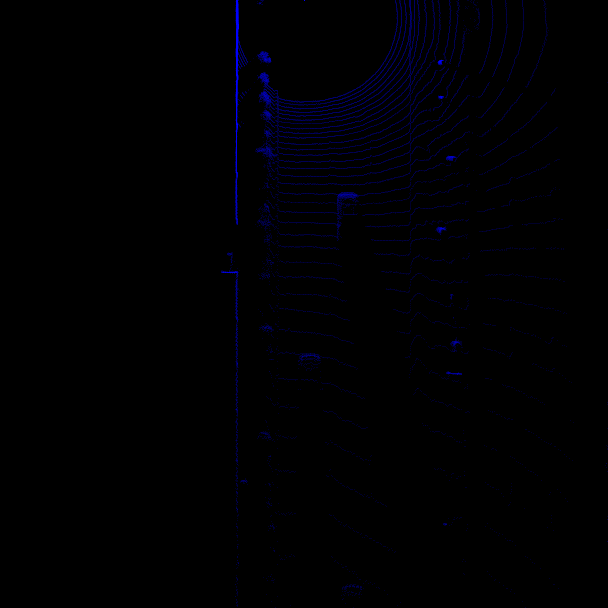

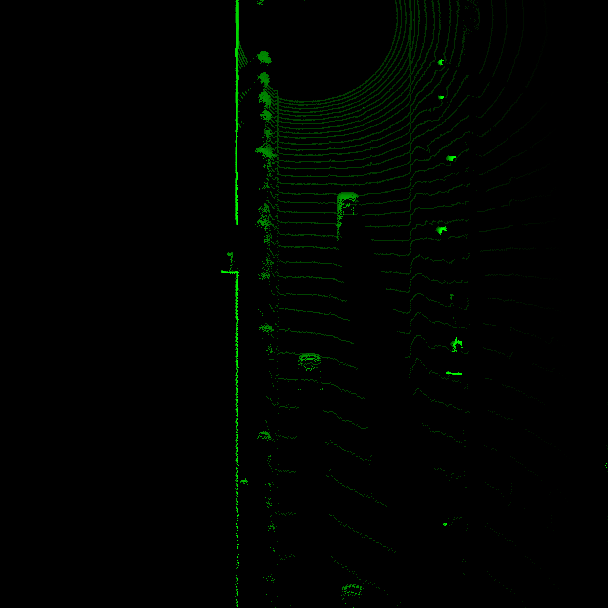

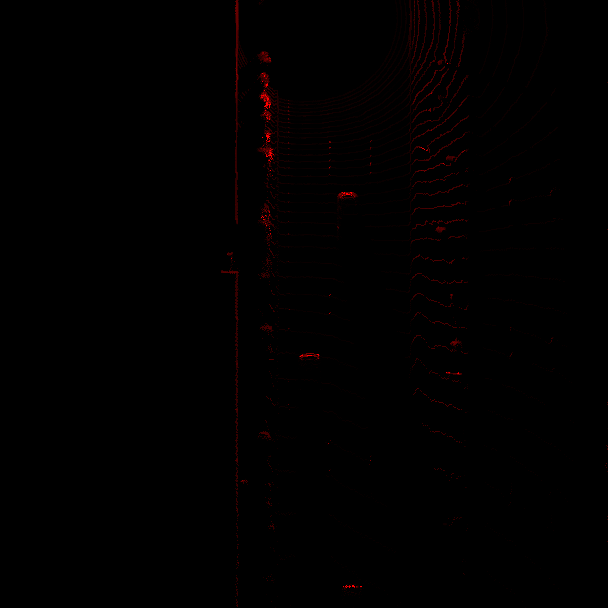

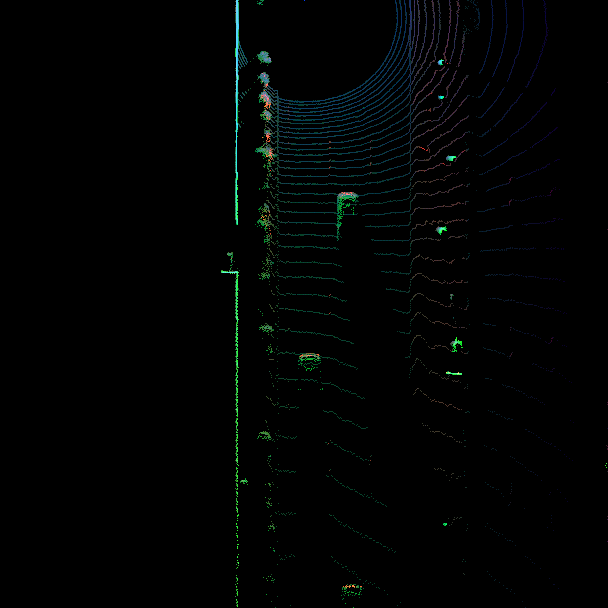

In [5]:

def pcl_to_bev(pcl:np.ndarray, configs: edict) -> np.ndarray:
    """Computes the bev map of a given pointcloud. 
    
    For generality, this method can return the bev map of the available 
    channels listed in '''BEVConfig.VALID_CHANNELS'''. 

    Parameters
    ----------
        pcl (np.ndarray): pointcloud as a numpy array of shape [n_points, m_channles] 
        configs (Dict): configuration parameters of the resulting bev_map

    Returns
    -------
        bev_map (np.ndarray): bev_map as numpy array of shape [len(config.channels), configs.bev_height, configs.bev_width ]
    """
    pcl = pcl.copy()
    # Step 1:
    # remove lidar points outside detection area
    mask = np.where((pcl[:, 0] >= configs.lims.x[0]) & (pcl[:, 0] <= configs.lims.x[1]) &
                    (pcl[:, 1] >= configs.lims.y[0]) & (pcl[:, 1] <= configs.lims.y[1]) &
                    (pcl[:, 2] >= configs.lims.z[0]) & (pcl[:, 2] <= configs.lims.z[1]))
    pcl = pcl[mask]
    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    pcl[:, 2] = pcl[:, 2] - configs.lims.z[0]
    # limit intensity values
    pcl[pcl[:,3]<configs.lims.intensity[0],3] = configs.lims.intensity[0]
    pcl[pcl[:,3]>configs.lims.intensity[1],3] = configs.lims.intensity[1]  

    # Step 2:
    # Convert sensor coordinates to bev-map coordinates (center is bottom-middle)
    # compute bev-map discretization by dividing x-range by the bev-image height
    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width
    
    # Step 3:
    ## transform all metrix x-coordinates into bev-image coordinates    
    pcl[:, 0] = np.int_(np.floor(pcl[:, 0] / bev_x_discret))
    # transform all y-coordinates making sure that no negative bev-coordinates occur
    pcl[:, 1] = np.int_(np.floor(pcl[:, 1] / bev_y_discret) + (configs.bev_width + 1) / 2) 
    
    # Step 4:
    # Sort poitncloud by x, y, and then z
    pcl_height_sorted, counts = sort_and_map(pcl, 2, return_counts=True)
    xs = np.int_(pcl_height_sorted[:, 0])
    ys = np.int_(pcl_height_sorted[:, 1])
    
    # Step 5:
    # Compute height channel
    normalized_height = pcl_height_sorted[:, 2]/float(np.abs(configs.lims.z[1] - configs.lims.z[0]))
    # Fill height map
    height_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    height_map[xs,ys] = normalized_height
    
    # Step 6:
    # Compute density channel
    normalized_density = np.minimum(1.0, np.log(counts + 1) / np.log(64))
    # Fill density map
    density_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    density_map[xs,ys] = normalized_density

    # Step 7:
    # Filter intensities that are bi    
    pcl_int_sorted, _ = sort_and_map(pcl, 3, return_counts=False)
    xs = np.int_(pcl_int_sorted[:, 0])
    ys = np.int_(pcl_int_sorted[:, 1])
    
    normalized_int = pcl_int_sorted[:, 3]/(np.amax(pcl_int_sorted[:, 3])-np.amin(pcl_int_sorted[:, 3]))

    intensity_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    intensity_map[xs,ys] = normalized_int

    # Step 8:    
    # Create BEV map
    bev_map = np.zeros((3, configs.bev_height, configs.bev_width))
    # Fill BEV 
    bev_map[2,:,:] = density_map[:configs.bev_height, :configs.bev_width]
    bev_map[1,:,:] = height_map[:configs.bev_height, :configs.bev_width]
    bev_map[0,:,:] = intensity_map[:configs.bev_height, :configs.bev_width]
 
    return bev_map

def sort_and_map(pcl: np.ndarray, channel_index: int, return_counts:bool=False) ->Tuple[np.ndarray,np.ndarray]:
    """Function to re-arrange elements in poincloud by sorting first by x, then y, then -channel.
    This function allows users to map a pointcloud channel to a top view image (in z axis) of that channel.

    Parameters
    ----------
        pcl (np.ndarray): Input pointcloud of of shape [n_points, m_channles]
        channel_index (int): Index of channel to take into account as third factor, 
                             when sorting the pointcloud.
        return_counts (bool): True to return the counts on points per cell. Used for density channel
    Returns
     ----------
       pcl_sorted (np.ndarray): Sorted poincloud by $x$, then $y$, then $-channel$. This function return only
                                one point per unique pair ($x$,$y$) with the maximum value in the $channel$ 
                                coordinate.
       counts (np.ndarray): Return the amount of points per unique pair ($x$,$y$) if return counts is true
                            or None otherwise.
       
    """

    idx= np.lexsort((-pcl[:, channel_index], pcl[:, 1], pcl[:, 0]))
    pcl_sorted = pcl[idx]
    counts = None
    # extract all points with identical x and y such that only the maximum value of the channel is kept
    if return_counts:
        _, indices, counts = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True, return_counts=return_counts)
    else:
        _, indices = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True)
    return (pcl_sorted[indices], counts)

def show_bev_map(bev_map: np.ndarray) -> None:
    """Function to show bev_map as an RGB image

    By default, the image will only show the 3 first channels of `bev_map`. 

    Parameters
    ----------
        bev_map (np.ndarray): bev_map as numpy array of shape `[len(config.channels), configs.bev_height, configs.bev_width ]` 
    """
    bev_image: np.ndarray =  (np.swapaxes(np.swapaxes(bev_map,0,1),1,2)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])


    height_image = Image.fromarray(np.dstack((bev_image[:, :, 0],mask,mask)))
    den_image = Image.fromarray(np.dstack((mask,bev_image[:, :, 1],mask)))
    int_image = Image.fromarray(np.dstack((mask,mask,bev_image[:, :, 2])))

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()


configs = edict()
configs.lims = edict()
configs.lims.x = [0, 50]
configs.lims.y = [-25, 25]
configs.lims.z = [-1, 3]
configs.lims.intensity = [0, 1]
configs.bev_height = 608
configs.bev_width = 608
bev_map = pcl_to_bev(pcl_2, configs)
show_bev_map(bev_map)